# East coast floods


In [1]:
import os
import datetime
import glob

from collections import Counter
import calendar
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy
import cartopy.crs as ccrs
import geopandas as gp
from IPython.display import Image
from scipy.stats import genextreme as gev
import xclim as xc
import cmocean
import seaborn as sns

from unseen import fileio
from unseen import general_utils
from unseen import time_utils
from unseen import indices

In [2]:
# Optional parameters 
# (This cell is tagged "parameters")
dpi = 300

In [3]:
# Parameters
agcd_file = "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_AGCD-CSIRO_r005_1900-2022_annual-aug-to-sep_east-coast-flood-region.zarr.zip"
model_file = "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_MRI-ESM2-0-dcppA-hindcast_196011-201911_annual-aug-to-sep_east-coast-flood-region.zarr.zip"
model_bc_file = "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_MRI-ESM2-0-dcppA-hindcast_196011-201911_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-multiplicative.zarr.zip"
similarity_bc_file = "/g/data/xv83/dbi599/east-coast-rain/data/similarity-test_Rx15day_MRI-ESM2-0-dcppA-hindcast_196011-201911_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-multiplicative.zarr.zip"
similarity_raw_file = "/g/data/xv83/dbi599/east-coast-rain/data/similarity-test_Rx15day_MRI-ESM2-0-dcppA-hindcast_196011-201911_annual-aug-to-sep_east-coast-flood-region_AGCD-CSIRO.zarr.zip"
independence_plot = "/g/data/xv83/dbi599/east-coast-rain/figures/independence-test_Rx15day_MRI-ESM2-0-dcppA-hindcast_196011-201911_annual-aug-to-sep_east-coast-flood-region.png"
model_name = "MRI-ESM2-0"
min_lead = 1
region_name = "east-coast-flood-region"
shape_file = "/g/data/xv83/dbi599/east-coast-rain/shapefiles/east-coast-flood.shp"
file_list = "file_lists/MRI-ESM2-0_dcppA-hindcast_pr_files.txt"
nino_file = "/g/data/xv83/dbi599/east-coast-rain/data/nino34-anomaly_MRI-ESM2-0-dcppA-hindcast_196011-201911_base-196011-201911.zarr.zip"


In [4]:
# Required parameters
assert 'model_name' in locals(), "Must provide a model name"
assert 'region_name' in locals(), "Must provide a region name"
assert 'min_lead' in locals(), "Must provide a minimum lead time"
assert os.path.isfile(file_list), "Must provide the input model files list (papermill option -p file_list [filepath])"
assert os.path.isfile(shape_file), "Must provide the shapefile (papermill option -p shape_file [filepath])"
assert os.path.isfile(agcd_file), "Must provide an AGCD data file (papermill option -p agcd_file [filepath])"
assert os.path.isfile(model_file), "Must provide an model data file (papermill option -p cafe_file [filepath])"
assert os.path.isfile(model_bc_file), "Must provide a model bias corrected data file (papermill option -p cafe_bc_file [filepath])"
assert os.path.isfile(nino_file), "Must provide a model Nino 3.4 data file (papermill option -p nino_file [filepath])"
assert os.path.isfile(similarity_bc_file), "Must provide an bias corrected similarity test file (papermill option -p similarity_bias_file [filepath])"
assert os.path.isfile(similarity_raw_file), "Must provide an raw data similarity test file (papermill option -p similarity_raw_file [filepath])"
assert os.path.isfile(independence_plot), "Must provide an independence test plot (papermill option -p independence_plot [filepath])"

## Observations

In [5]:
agcd_ds = fileio.open_dataset(agcd_file)
agcd_ds = agcd_ds.dropna('time')

In [6]:
agcd_ds

<xarray.Dataset>
Dimensions:     (time: 122)
Coordinates:
    event_time  (time) <U28 dask.array<chunksize=(122,), meta=np.ndarray>
  * time        (time) object 1901-01-01 09:00:00 ... 2022-01-01 09:00:00
Data variables:
    pr          (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/33)
    CDI:                           Climate Data Interface version ?? (http://...
    CDO:                           Climate Data Operators version 1.7.0 (http...
    Conventions:                   CF-1.6
    acknowledgment:                The Australian Government, Bureau of Meteo...
    analysis_components:           total: the gridded accumulation of rainfall.
    bom-cmp-awap_version:          bom-cmp-awap-1.00-89.0.x86_64
    ...                            ...
    summary:                       The daily and monthly rainfall data repres...
    time_coverage_end:             1900-01-01T09:00:00
    time_coverage_start:           1899-12-31T09:00:00
    title:                         Interpolated Rain Gauge Precipitation
    url:                           http://www.bom.gov.au/climate/
    uuid:                          14333ae2-28fe-4cb6-9f00-677adc94f25e

In [7]:
years = agcd_ds['time'].dt.year.values
agcd_df = pd.DataFrame(index=years)
agcd_df['pr'] = agcd_ds['pr'].values

In [8]:
pr2022 = agcd_ds['pr'].values.max()
print(pr2022)

410.43057


## Model ensemble

### Region selection

In [9]:
with open(file_list) as f:
    all_files = f.read()
    first_file = all_files.split('\n', 1)[0]

In [10]:
first_file

'/g/data/oi10/replicas/CMIP6/DCPP/MRI/MRI-ESM2-0/dcppA-hindcast/s1960-r1i1p1f1/day/pr/gn/v20210122/pr_day_MRI-ESM2-0_dcppA-hindcast_s1960-r1i1p1f1_gn_19601101-19651231.nc'

In [11]:
shapes = gp.read_file(shape_file)

In [12]:
isel_dict = {'time': 0}
if model_name == 'CAFE':
    isel_dict['ensemble'] = 0
    metadata_file = '/home/599/dbi599/unseen/config/dataset_cafe_daily.yml'
else:
    metadata_file = None

In [13]:
region_ds = fileio.open_dataset(
    first_file,
    metadata_file=metadata_file,
    variables=['pr'],
    lat_bnds=[-40, -20],
    lon_bnds=[140, 160],
    shapefile=shape_file,
    shape_overlap=0.1,
    units={'pr': 'mm day-1'},
    isel=isel_dict,
)

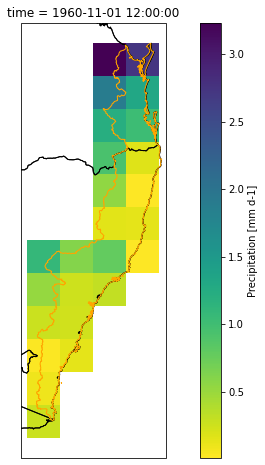

In [14]:
fig = plt.figure(figsize=[12,8])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
region_ds['pr'].plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='viridis_r',
)
ax.coastlines()
ax.add_feature(cartopy.feature.STATES)
ax.add_geometries(shapes.geometry, ccrs.PlateCarree(), facecolor='none', edgecolor='orange')
plt.show()

### Model data

In [15]:
model_ds = fileio.open_dataset(model_file)
model_bc_ds = fileio.open_dataset(model_bc_file)

In [16]:
model_ds

<xarray.Dataset>
Dimensions:     (ensemble: 10, init_date: 60, lead_time: 6)
Coordinates:
  * ensemble    (ensemble) int64 0 1 2 3 4 5 6 7 8 9
    event_time  (init_date, ensemble, lead_time) <U28 dask.array<chunksize=(60, 10, 6), meta=np.ndarray>
  * init_date   (init_date) object 1960-11-01 00:00:00 ... 2019-11-01 00:00:00
  * lead_time   (lead_time) int64 0 1 2 3 4 5
    time        (lead_time, init_date) object dask.array<chunksize=(6, 60), meta=np.ndarray>
Data variables:
    pr          (init_date, ensemble, lead_time) float64 dask.array<chunksize=(1, 1, 6), meta=np.ndarray>
Attributes: (12/44)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            DCPP
    branch_method:          standard
    branch_time_in_child:   40481.0
    branch_time_in_parent:  40481.0
    cmor_version:           3.5.0
    ...                     ...
    table_id:               day
    table_info:             Creation Date:(24 July 2019) MD5:36f28a6dd43b853e...
    title:                  MRI-ESM2-0 output prepared for CMIP6
    tracking_id:            hdl:21.14100/d5249c9d-01a4-4e2d-83c5-47bc7da26c63
    variable_id:            pr
    variant_label:          r1i1p1f1

### Independence testing

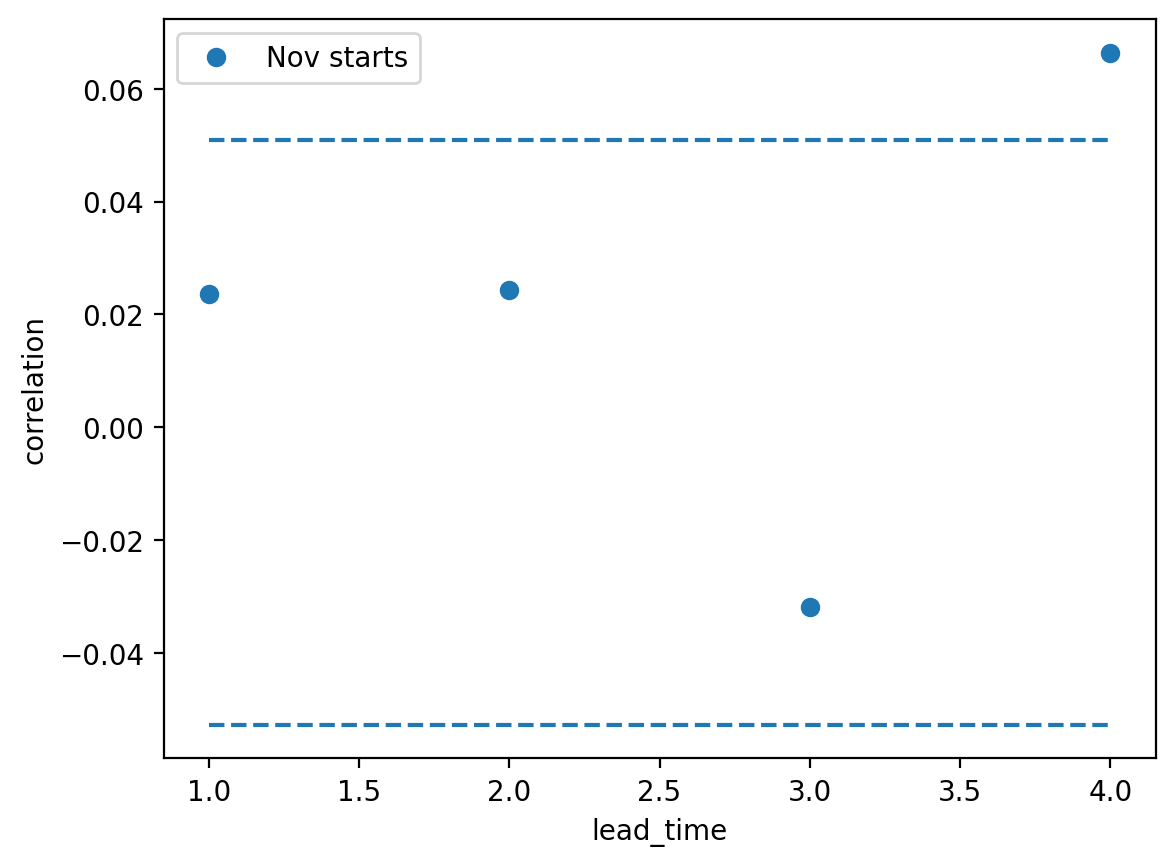

In [17]:
Image(filename=independence_plot)

In [18]:
print(min_lead)

1


In [19]:
model_da = model_ds['pr'].where(model_ds['lead_time'] >= min_lead)

In [20]:
model_da_stacked = model_da.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [21]:
model_da_stacked.shape

(2400,)

In [22]:
model_bc_da_stacked = model_bc_ds.dropna('lead_time')['pr'].stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [23]:
model_bc_da_stacked.shape

(2400,)

### Bias correction and similarity testing

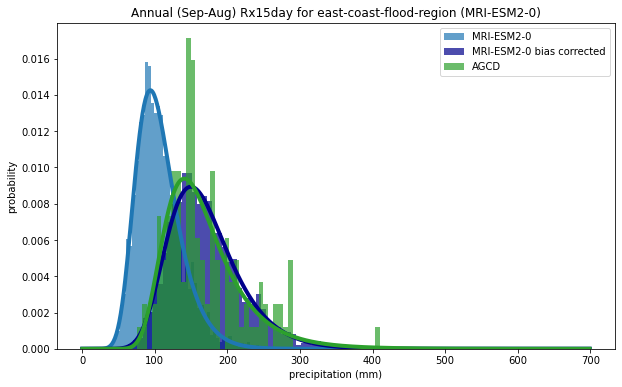

In [24]:
fig = plt.figure(figsize=[10, 6])
gev_xvals = np.arange(0, 700)

model_da.plot.hist(
    bins=50, density=True, label=model_name, alpha=0.7, facecolor='tab:blue',
)
model_gev_shape, model_gev_loc, model_gev_scale = indices.fit_gev(model_da_stacked.values)
model_gev_pdf = gev.pdf(gev_xvals, model_gev_shape, model_gev_loc, model_gev_scale)
plt.plot(gev_xvals, model_gev_pdf, color='tab:blue', linewidth=4.0)

model_bc_ds['pr'].plot.hist(
    bins=50, density=True, label=f'{model_name} bias corrected', facecolor='darkblue', alpha=0.7
)
model_bc_gev_shape, model_bc_gev_loc, model_bc_gev_scale = indices.fit_gev(model_bc_da_stacked.values)
model_bc_gev_pdf = gev.pdf(gev_xvals, model_bc_gev_shape, model_bc_gev_loc, model_bc_gev_scale)
plt.plot(gev_xvals, model_bc_gev_pdf, color='darkblue', linewidth=4.0)

agcd_ds['pr'].plot.hist(
    bins=50, density=True, label='AGCD', facecolor='tab:green', alpha=0.7
)
agcd_gev_shape, agcd_gev_loc, agcd_gev_scale = indices.fit_gev(agcd_ds['pr'].values)
agcd_gev_pdf = gev.pdf(gev_xvals, agcd_gev_shape, agcd_gev_loc, agcd_gev_scale)
plt.plot(gev_xvals, agcd_gev_pdf, color='tab:green', linewidth=4.0)

plt.xlabel('precipitation (mm)')
plt.ylabel('probability')
plt.title(f'Annual (Sep-Aug) Rx15day for {region_name} ({model_name})')
plt.legend()
plt.savefig(f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_histogram_{model_name}_{region_name}.png',
            bbox_inches='tight', facecolor='white', dpi=dpi)
plt.show()

We can look at p-values for the KS-test and Anderson-Darling test for each lead time.

p > 0.05 means the null hypothesis (that the two samples are from the same population) can't be rejected.

In [25]:
similarity_raw_ds = fileio.open_dataset(similarity_raw_file)

In [26]:
similarity_raw_ds['ks_pval'].values

array([5.551115e-16, 5.551115e-16, 5.551115e-16, 5.551115e-16],
      dtype=float32)

In [27]:
similarity_raw_ds['ad_pval'].values

array([0.001, 0.001, 0.001, 0.001], dtype=float32)

In [28]:
similarity_bias_ds = fileio.open_dataset(similarity_bc_file)

In [29]:
similarity_bias_ds['ks_pval'].values

array([0.7978798 , 0.74179184, 0.41870183, 0.68100625], dtype=float32)

In [30]:
similarity_bias_ds['ad_pval'].values

array([0.25, 0.25, 0.25, 0.25], dtype=float32)

### Exceedance curves

In [31]:
def plot_exceedance(sample_ds, model_name, outfile=None):
    """Plot single exceedance curve"""
    
    sorted_data, exceedance_data = general_utils.exceedance_curve(sample_ds)
    
    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot()
    ax.plot(sorted_data, exceedance_data)
    ax.set_title(f'Annual (Sep-Aug) Rx15day for {region_name} ({model_name})')
    ax.set_ylabel('likelihood of exceedance (%)')
    ax.set_xlabel('Rx15day precipitation (mm)')
    ax.axvline(pr2022, color='0.5', linestyle='--')
    if outfile:
        plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
        print(outfile)
    else:
        plt.show()

In [32]:
def gev_event_likelihood(event, shape, loc, scale):
    """Get likelihood stats for an event from a GEV fit"""

    probability = gev.sf(event, shape, loc=loc, scale=scale)
    return_period = 1. / probability
    percentile = (1 - probability) * 100
    print(f'{percentile:.2f}% percentile')
    print(f'{return_period:.0f} year return period\n')

In [33]:
def plot_exceedance_by_decade(sample_ds, model_name):
    """Plot exceedance curve by decade"""

    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot()
    if model_name == 'CAFE':
        start_years = [1995, 2000, 2005, 2010, 2015]
        step = 4
    else:
        start_years = [1960, 1970, 1980, 1990, 2000, 2010]
        step = 9
    colors = iter(plt.cm.hot_r(np.linspace(0.3, 1, len(start_years))))

    for start_year in start_years:
        end_year = start_year + step
        start_date = f'{start_year}-01-01'
        end_date = f'{end_year}-12-25'
        ds_selection = time_utils.select_time_period(sample_ds, [start_date, end_date])
        ds_selection = ds_selection.dropna('sample')
        sorted_data, exceedance_data = general_utils.exceedance_curve(ds_selection)
        n_years = len(sorted_data)
        label = f'{start_year}-{end_year} ({n_years} samples)'
        color = next(colors)
        ax.plot(sorted_data, exceedance_data, label=label, color=color)
    
        print(f'{start_year}-{end_year}')
        n_events, n_population, return_period, percentile = general_utils.event_in_context(ds_selection.values, pr2022, 'above')
        print(f'{n_events} events in {n_population} samples')
        print(f'{percentile:.2f}% percentile')
        print(f'{return_period:.0f} year return period')
        print('GEV:')
        gev_shape, gev_loc, gev_scale = indices.fit_gev(ds_selection.values)
        gev_event_likelihood(pr2022, gev_shape, gev_loc, gev_scale)

    ax.set_title(f'Annual (Sep-Aug) Rx15day for {region_name} ({model_name})')
    ax.set_ylabel('likelihood of exceedance (%)')
    ax.set_xlabel('Rx15day precipitation (mm)')
    ax.legend()
    ax.axvline(pr2022, color='0.5', linestyle='--')
    outfile = f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_precip_exceedence_{region_name}_{model_name}_by-decade.png'
    plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
    print(outfile)

#### Bias corrected data

/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_precip_exceedence_east-coast-flood-region_MRI-ESM2-0.png


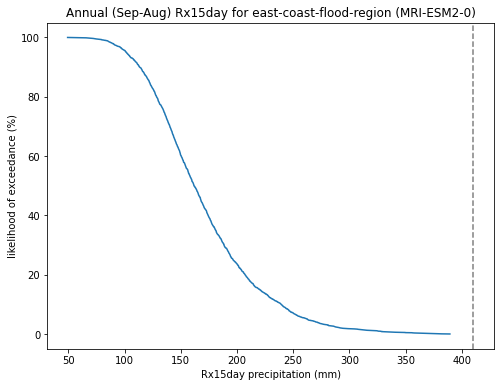

In [34]:
outfile = f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_precip_exceedence_{region_name}_{model_name}.png'
plot_exceedance(model_bc_da_stacked, model_name, outfile=outfile)

In [35]:
n_events_bc, n_population_bc, return_period_bc, percentile_bc = general_utils.event_in_context(model_bc_da_stacked.values, pr2022, 'above')
print('BIAS CORRECTED DATA')
print(f'{n_events_bc} events in {n_population_bc} samples')
print(f'{percentile_bc:.2f}% percentile')
print(f'{return_period_bc:.0f} year return period')

BIAS CORRECTED DATA
0 events in 2400 samples
100.00% percentile
inf year return period


/home/599/dbi599/unseen/unseen/general_utils.py:151: RuntimeWarning: divide by zero encountered in long_scalars
  return_period = n_population / n_events


In [36]:
print('BIAS CORRECTED GEV')
gev_event_likelihood(pr2022, model_bc_gev_shape, model_bc_gev_loc, model_bc_gev_scale)

BIAS CORRECTED GEV
99.94% percentile
1814 year return period



1960-1969


/home/599/dbi599/unseen/unseen/general_utils.py:151: RuntimeWarning: divide by zero encountered in long_scalars
  return_period = n_population / n_events


0 events in 300 samples
100.00% percentile
inf year return period
GEV:
99.93% percentile
1414 year return period

1970-1979


/home/599/dbi599/unseen/unseen/general_utils.py:151: RuntimeWarning: divide by zero encountered in long_scalars
  return_period = n_population / n_events


0 events in 400 samples
100.00% percentile
inf year return period
GEV:
99.99% percentile
8448 year return period

1980-1989


/home/599/dbi599/unseen/unseen/general_utils.py:151: RuntimeWarning: divide by zero encountered in long_scalars
  return_period = n_population / n_events


0 events in 400 samples
100.00% percentile
inf year return period
GEV:
99.86% percentile
712 year return period

1990-1999


/home/599/dbi599/unseen/unseen/general_utils.py:151: RuntimeWarning: divide by zero encountered in long_scalars
  return_period = n_population / n_events


0 events in 400 samples
100.00% percentile
inf year return period
GEV:
99.90% percentile
968 year return period

2000-2009


/home/599/dbi599/unseen/unseen/general_utils.py:151: RuntimeWarning: divide by zero encountered in long_scalars
  return_period = n_population / n_events


0 events in 400 samples
100.00% percentile
inf year return period
GEV:
99.96% percentile
2386 year return period

2010-2019


/home/599/dbi599/unseen/unseen/general_utils.py:151: RuntimeWarning: divide by zero encountered in long_scalars
  return_period = n_population / n_events


0 events in 400 samples
100.00% percentile
inf year return period
GEV:
99.91% percentile
1125 year return period

/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_precip_exceedence_east-coast-flood-region_MRI-ESM2-0_by-decade.png


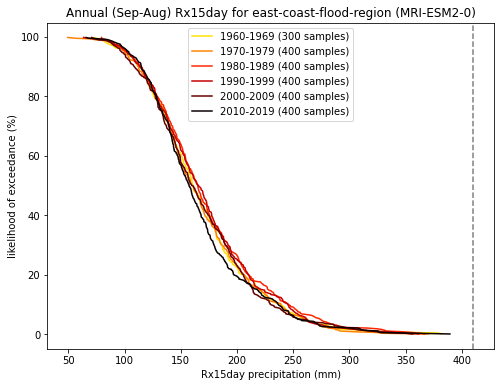

In [37]:
plot_exceedance_by_decade(model_bc_da_stacked, model_name)

#### Raw data

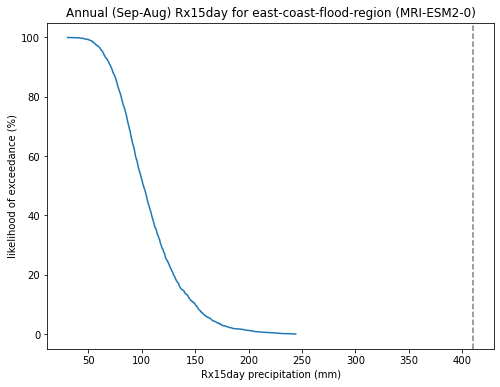

In [38]:
plot_exceedance(model_da_stacked, model_name)

In [39]:
n_events, n_population, return_period, percentile = general_utils.event_in_context(model_da_stacked.values, pr2022, 'above')
print('RAW DATA')
print(f'{n_events} events in {n_population} samples')
print(f'{percentile:.2f}% percentile')
print(f'{return_period:.0f} year return period')

RAW DATA
0 events in 2400 samples
100.00% percentile
inf year return period


/home/599/dbi599/unseen/unseen/general_utils.py:151: RuntimeWarning: divide by zero encountered in long_scalars
  return_period = n_population / n_events


In [40]:
print('RAW GEV')
gev_event_likelihood(pr2022, model_gev_shape, model_gev_loc, model_gev_scale)

RAW GEV
100.00% percentile
52744325 year return period



### Seasonality

In [41]:
model_df = model_da_stacked.to_dataframe()
model_df = model_df.dropna()
model_df = model_df.reset_index()
model_df

,ensemble,init_date,lead_time,event_time,time,pr
0,0,1960-11-01 00:00:00,1,1962-01-27,1961-11-01 12:00:00,52.384304
1,0,1960-11-01 00:00:00,2,1963-07-02,1962-11-01 12:00:00,114.183830
2,0,1960-11-01 00:00:00,3,1963-11-06,1963-11-02 12:00:00,99.700030
3,0,1960-11-01 00:00:00,4,1965-02-06,1964-11-01 12:00:00,160.804310
4,0,1961-11-01 00:00:00,1,1963-08-12,1962-11-01 12:00:00,90.908210
...,...,...,...,...,...,...
2395,9,2018-11-01 00:00:00,4,2023-06-17,2022-11-01 12:00:00,134.045977
2396,9,2019-11-01 00:00:00,1,2021-04-25,2020-10-31 12:00:00,184.779343
2397,9,2019-11-01 00:00:00,2,2022-06-23,2021-10-31 12:00:00,137.163258
2398,9,2019-11-01 00:00:00,3,2023-02-17,2022-10-31 12:00:00,144.224243


In [42]:
event_months = [int(date[5:7]) for date in model_df['event_time'].values]
event_years = [int(date[0:4]) for date in model_df['event_time'].values]

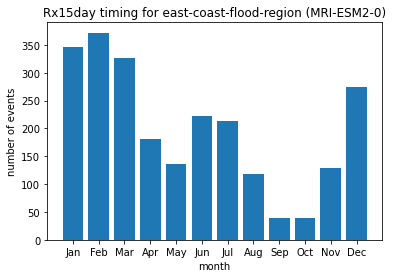

In [43]:
month_counts = Counter(event_months)
months = np.arange(1, 13)
counts = [month_counts[month] for month in months]

plt.bar(months, counts)
plt.title(f'Rx15day timing for {region_name} ({model_name})')
plt.ylabel('number of events')
plt.xlabel('month')
xlabels = [calendar.month_abbr[i] for i in months]
plt.xticks(months, xlabels)
#plt.savefig(
#    f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_timing_AGCD_{region_name}.png',
#    bbox_inches='tight',
#    facecolor='white',
#    dpi=dpi
#)
plt.show()

### Relationship with ENSO

In [44]:
nino_ds = fileio.open_dataset(nino_file)
nino_ds = nino_ds.assign_coords({'init_date': [date.strftime('%Y%m') for date in nino_ds['init_date'].values]})
nino_ds

<xarray.Dataset>
Dimensions:    (ensemble: 10, init_date: 60, lead_time: 62)
Coordinates:
  * ensemble   (ensemble) int64 0 1 2 3 4 5 6 7 8 9
  * init_date  (init_date) <U6 '196011' '196111' '196211' ... '201811' '201911'
  * lead_time  (lead_time) int64 0 1 2 3 4 5 6 7 8 ... 54 55 56 57 58 59 60 61
    time       (lead_time, init_date) object dask.array<chunksize=(62, 60), meta=np.ndarray>
Data variables:
    tos        (init_date, ensemble, lead_time) float32 dask.array<chunksize=(1, 1, 62), meta=np.ndarray>
Attributes:
    history:  Thu Feb 02 16:33:25 2023: /g/data/xv83/dbi599/miniconda3/envs/u...

In [45]:
nino_values = []
for index, row in model_df.iterrows():
    event_init_date = row['init_date'].strftime('%Y%m')
    event_ensemble = row['ensemble']
    event_year_month = row['time'].strftime('%Y-%m')
    nino_selection = nino_ds.sel({'init_date': event_init_date, 'ensemble': event_ensemble})
    nino_selection = nino_selection.swap_dims({'lead_time': 'time'})
    nino_year_month = [date.strftime('%Y-%m') for date in nino_selection['time'].values]
    nino_selection = nino_selection.assign_coords({'time': nino_year_month})
    nino_value = float(nino_selection['tos'].sel({'time': event_year_month}).values)
    nino_values.append(nino_value)

In [46]:
model_df['nino34'] = nino_values

/g/data/xv83/dbi599/miniconda3/envs/unseen/lib/python3.9/site-packages/seaborn/distributions.py:1182: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


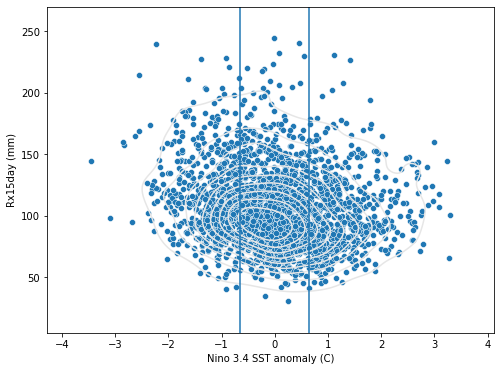

In [47]:
fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(111)

sns.scatterplot(ax=ax, data=model_df, x='nino34', y='pr')
sns.kdeplot(ax=ax, data=model_df, x='nino34', y='pr', color='0.9', linewidth=1)

ax.set_ylabel('Rx15day (mm)')
ax.set_xlabel('Nino 3.4 SST anomaly (C)')
ax.axvline(0.65)
ax.axvline(-0.65)
plt.show()

### Meteorology

In [48]:
def plot_average(color_da, color_var, contour_da, contour_var, start_date, end_date):
    """Plot average"""
    
    fig = plt.figure(figsize=[10, 5])
    map_proj=ccrs.PlateCarree(central_longitude=180)
    ax1 = fig.add_subplot(1, 1, 1, projection=map_proj)       
    
    if color_var == 'pr':
        levels = [0, 100, 200, 300, 400, 500, 600, 700, 800]
        label = 'total precipitation (mm)'
        cmap = cmocean.cm.rain
        extend = 'max'
    elif color_var == 'ua300':
        levels = [-30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30]
        label = '300hPa zonal wind'
        cmap='RdBu_r'
        extend = 'both'
    else:
        raise ValueError('Invalid color variable')
    color_da.plot(
        ax=ax1,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        levels=levels,
        extend=extend,
        cbar_kwargs={'label': label},
    )
    
    if contour_var == 'z500':
        levels = np.arange(5000, 6300, 50)
    elif contour_var == 'psl':
        levels = np.arange(900, 1100, 2.5)
    elif contour_var == 'ua300':
        levels = np.arange(15, 60, 5)
    else:
        raise ValueError('Invalid contour variable')
    lines = contour_da.plot.contour(
        ax=ax1,
        transform=ccrs.PlateCarree(),
        levels=levels,
        colors=['0.1']
    )
    ax1.clabel(lines, colors=['0.1'], manual=False, inline=True)
    
    ax1.coastlines()
    ax1.set_extent([90, 205, -55, 10], crs=ccrs.PlateCarree())
    ax1.gridlines(linestyle='--', draw_labels=True)
    ax1.set_title(f'Average {contour_var} ({contour_da.units}), {start_date} to {end_date}')
#    plt.savefig(
#        f'/home/599/dbi599/east-coast-rain/{color_var}-{contour_var}_mean_BARRA2_{start_date}_{end_date}.png',
#        bbox_inches='tight',
#        facecolor='white',
#        dpi=300
#    )
    plt.show()

In [49]:
ranked_events = model_df.sort_values(by=['pr'], ascending=False)
ranked_events.head(n=10)

,ensemble,init_date,lead_time,event_time,time,pr,nino34
1877,7,2009-11-01 00:00:00,2,2012-03-09,2011-11-02 12:00:00,244.063039,-0.019844
1224,5,1966-11-01 00:00:00,1,1968-07-09,1967-11-02 12:00:00,240.000518,0.449129
1687,7,1961-11-01 00:00:00,4,1966-02-25,1965-11-01 12:00:00,239.506933,-2.227240
1918,7,2019-11-01 00:00:00,3,2023-02-02,2022-10-31 12:00:00,232.580031,0.072571
2264,9,1986-11-01 00:00:00,1,1988-02-23,1987-11-02 12:00:00,230.581161,1.108925
770,3,1972-11-01 00:00:00,3,1976-08-04,1975-11-02 12:00:00,230.067726,0.547125
1308,5,1987-11-01 00:00:00,1,1989-03-20,1988-10-31 12:00:00,227.752789,-0.912783
2280,9,1990-11-01 00:00:00,1,1992-03-12,1991-11-02 12:00:00,227.368849,-1.385912
1871,7,2007-11-01 00:00:00,4,2012-03-30,2011-11-01 12:00:00,226.241207,1.418694
1117,4,1999-11-01 00:00:00,2,2002-03-03,2001-10-31 12:00:00,223.261858,-0.033007


In [50]:
model_bc_df = model_bc_ds['pr'].to_dataframe()
model_bc_df = model_bc_df.dropna()
model_bc_df = model_bc_df.reset_index()
ranked_bc_events = model_bc_df.sort_values(by=['pr'], ascending=False)
ranked_bc_events.head(n=10)

,init_date,ensemble,lead_time,event_time,time,pr
1989,2009-11-01 00:00:00,7,2,2012-03-09,2011-11-02 12:00:00,389.484989
260,1966-11-01 00:00:00,5,1,1968-07-09,1967-11-02 12:00:00,382.045073
71,1961-11-01 00:00:00,7,4,1966-02-25,1965-11-01 12:00:00,378.970602
2390,2019-11-01 00:00:00,7,3,2023-02-02,2022-10-31 12:00:00,374.551170
494,1972-11-01 00:00:00,3,3,1976-08-04,1975-11-02 12:00:00,370.505309
1076,1986-11-01 00:00:00,9,1,1988-02-23,1987-11-02 12:00:00,367.050859
1100,1987-11-01 00:00:00,5,1,1989-03-20,1988-10-31 12:00:00,362.548513
1236,1990-11-01 00:00:00,9,1,1992-03-12,1991-11-02 12:00:00,361.937337
1911,2007-11-01 00:00:00,7,4,2012-03-30,2011-11-01 12:00:00,357.980310
1577,1999-11-01 00:00:00,4,2,2002-03-03,2001-10-31 12:00:00,356.289681


2009 (2012-03-09), ensemble: r8, 244.06303880709729mm


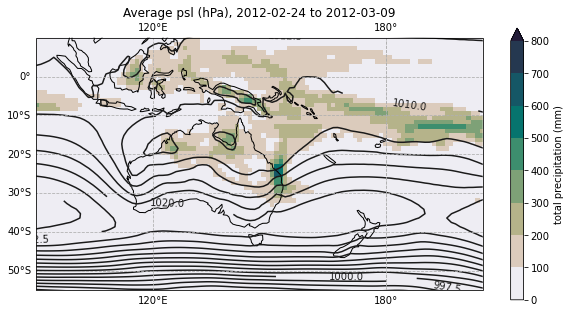

1966 (1968-07-09), ensemble: r6, 240.00051844030514mm


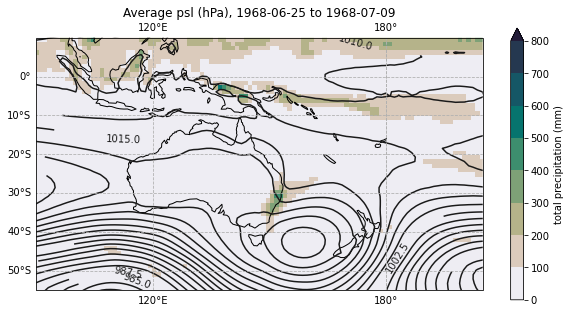

1961 (1966-02-25), ensemble: r8, 239.50693336652037mm


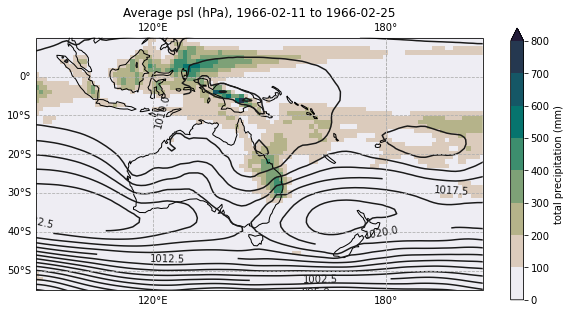

2019 (2023-02-02), ensemble: r8, 232.58003084080354mm


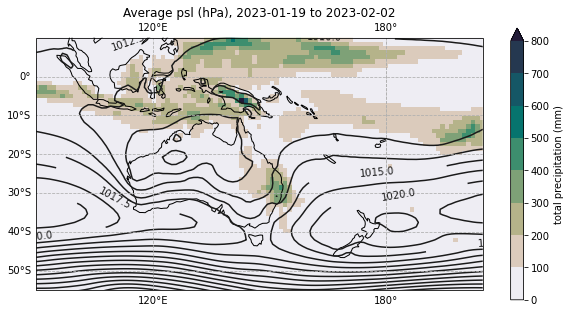

In [55]:
for index, row in ranked_events.head(n=4).iterrows():
    init_date = int(row['init_date'].strftime('%Y'))
    ensemble = int(row['ensemble']) + 1
    end_date = row['event_time']
    rx_value = row['pr']
    print(f'{init_date} ({end_date}), ensemble: r{ensemble}, {rx_value}mm')
    
    start_datetime = datetime.datetime.strptime(end_date, "%Y-%m-%d") - datetime.timedelta(days=14)
    start_date = start_datetime.strftime("%Y-%m-%d")
    
    pr_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/MRI/MRI-ESM2-0/dcppA-hindcast/s{init_date}-r{ensemble}i1p1f1/day/pr/gn/*/*.nc')
    pr_files.sort()
    ds_pr = fileio.open_dataset(pr_files, variables=['pr'],)
    
    psl_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/MRI/MRI-ESM2-0/dcppA-hindcast/s{init_date}-r{ensemble}i1p1f1/day/psl/gn/*/*.nc')
    psl_files.sort()
    ds_psl = fileio.open_dataset(psl_files, variables=['psl'],)
    
#    zg_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/MIROC/MIROC6/dcppA-hindcast/s{init_date}-r{ensemble}i1p1f1/day/zg/gn/v20191217/*.nc')
#    zg_files.sort()
#    ds_zg = fileio.open_dataset(zg_files, variables=['zg'],)
    
#    ua_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/MIROC/MIROC6/dcppA-hindcast/s{init_date}-r{ensemble}i1p1f1/day/ua/gn/v20191217/*.nc')
#    ua_files.sort()
#    ds_ua = fileio.open_dataset(ua_files, variables=['ua'],)
    
#    zg_da = ds_zg.sel({'time': slice(start_date, end_date)})['zg']
#    z500_da = zg_da.sel({'plev': 50000}, method='nearest')
    pr_da = ds_pr.sel({'time': slice(start_date, end_date)})['pr']
    pr_da = xc.units.convert_units_to(pr_da, 'mm d-1')
    psl_da = ds_psl.sel({'time': slice(start_date, end_date)})['psl']
    psl_da = xc.units.convert_units_to(psl_da, 'hPa')
#    ua_da = ds_ua.sel({'time': slice(start_date, end_date)})['ua']
#    ua300_da = ua_da.sel({'plev': 30000}, method='nearest')

#    z500_da_mean = z500_da.mean('time', keep_attrs=True)
    pr_da_sum = pr_da.sum('time', keep_attrs=True)
    psl_da_mean = psl_da.mean('time', keep_attrs=True)
#    ua300_da_mean = ua300_da.mean('time', keep_attrs=True) 

#    plot_average(pr_da_sum, 'pr', z500_da_mean, 'z500', start_date, end_date)
    plot_average(pr_da_sum, 'pr', psl_da_mean, 'psl', start_date, end_date)
#    plot_average(ua300_da_mean, 'ua300', z500_da_mean, 'z500', start_date, end_date)